# Your Second Image Classifier: Using CNN to Classify Images
# Train

The purpose of this dataset is to correctly classify an image as containing a dog, cat, or panda.
Containing only 3,000 images, the Animals dataset is meant to be another **introductory** dataset
that we can quickly train a CNN model.


Let's take the following steps:

1. Encoding target variable
2. Training the CNN model
3. Export the model and the encoder object

<center><img width="900" src="https://drive.google.com/uc?export=view&id=1haMB_Zt6Et9q9sPHxfuR4g3FT5QRXlTI"></center>


## Step 01: Setup

Start out by installing the experiment tracking library and setting up your free W&B account:


*   **pip install wandb** – Install the W&B library
*   **import wandb** – Import the wandb library
*   **wandb login** – Login to your W&B account so you can log all your metrics in one place

In [1]:
!pip install wandb -qU

     |████████████████████████████████| 1.9 MB 4.7 MB/s 
     |████████████████████████████████| 166 kB 79.6 MB/s 
     |████████████████████████████████| 182 kB 82.7 MB/s 
     |████████████████████████████████| 63 kB 2.2 MB/s 
     |████████████████████████████████| 166 kB 92.1 MB/s 
     |████████████████████████████████| 162 kB 91.6 MB/s 
     |████████████████████████████████| 162 kB 91.6 MB/s 
     |████████████████████████████████| 158 kB 89.7 MB/s 
     |████████████████████████████████| 157 kB 90.3 MB/s 
     |████████████████████████████████| 157 kB 89.8 MB/s 
     |████████████████████████████████| 157 kB 89.0 MB/s 
     |████████████████████████████████| 157 kB 92.4 MB/s 
     |████████████████████████████████| 157 kB 97.5 MB/s 
     |████████████████████████████████| 157 kB 96.1 MB/s 
     |████████████████████████████████| 157 kB 92.6 MB/s 
     |████████████████████████████████| 156 kB 73.8 MB/s 


In [2]:
# a Python package for tracking the carbon emissions produced by various
# kinds of computer programs, from straightforward algorithms to deep neural networks.
!pip install codecarbon

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 174 kB 4.7 MB/s 
     |████████████████████████████████| 99 kB 11.3 MB/s 
     |████████████████████████████████| 46 kB 5.5 MB/s 
     |████████████████████████████████| 66 kB 6.2 MB/s 
  Created wheel for py-cpuinfo: filename=py_cpuinfo-8.0.0-py3-none-any.whl size=22257 sha256=3f39bb8d73a115dda64ed8b30cc5ecd6806f57ee9b243d513b71b383f3b28f81
  Stored in directory: /root/.cache/pip/wheels/d2/f1/1f/041add21dc9c4220157f1bd2bd6afe1f1a49524c3396b94401
Successfully built py-cpuinfo


### Import Packages

In [3]:
# import the necessary packages
import logging
import joblib
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
import numpy as np
from codecarbon import EmissionsTracker
from tensorflow.keras.callbacks import Callback
from wandb.keras import WandbCallback
import wandb
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
from tensorflow.keras.optimizers import SGD,Adam
import os
from sklearn.metrics import classification_report
from sklearn.metrics import fbeta_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [4]:
wandb.login()

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 

··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [5]:
# configure logging
# reference for a logging obj
logger = logging.getLogger()

# set level of logging
logger.setLevel(logging.INFO)

# create handlers
c_handler = logging.StreamHandler()
c_format = logging.Formatter(fmt="%(asctime)s %(message)s",datefmt='%d-%m-%Y %H:%M:%S')
c_handler.setFormatter(c_format)

# add handler to the logger
logger.handlers[0] = c_handler

## Step 02 Basic configuration and download artifacts

In [6]:
# since we are using Jupyter Notebooks we can replace our argument
# parsing code with *hard coded* arguments and values
args = {
  "project_name": "alexnet",
  "train_feature_artifact": "train_x:latest",
  "train_target_artifact": "train_y:latest",
  "val_feature_artifact": "val_x:latest",
  "val_target_artifact": "val_y:latest",
  "encoder": "target_encoder",
  "inference_model": "model.h5"
}

In [7]:
# open the W&B project created in the Fetch step
run = wandb.init(entity="ivanovitch-silva",project=args["project_name"], job_type="Train")

logger.info("Downloading the train and validation data")
# train x
train_x_artifact = run.use_artifact(args["train_feature_artifact"])
train_x_path = train_x_artifact.file()

# train y
train_y_artifact = run.use_artifact(args["train_target_artifact"])
train_y_path = train_y_artifact.file()

# validation x
val_x_artifact = run.use_artifact(args["val_feature_artifact"])
val_x_path = val_x_artifact.file()

# validation y
val_y_artifact = run.use_artifact(args["val_target_artifact"])
val_y_path = val_y_artifact.file()

# unpacking the artifacts
train_x = joblib.load(train_x_path)
train_y = joblib.load(train_y_path)
val_x = joblib.load(val_x_path)
val_y = joblib.load(val_y_path)

wandb: Currently logged in as: ivanovitch-silva. Use `wandb login --relogin` to force relogin


25-10-2022 11:57:45 Downloading the train and validation data


In [8]:
logger.info("Train x: {}".format(train_x.shape))
logger.info("Train y: {}".format(train_y.shape))
logger.info("Validation x: {}".format(val_x.shape))
logger.info("Validation y: {}".format(val_y.shape))

25-10-2022 11:58:18 Train x: (1687, 227, 227, 3)
25-10-2022 11:58:18 Train y: (1687,)
25-10-2022 11:58:18 Validation x: (563, 227, 227, 3)
25-10-2022 11:58:18 Validation y: (563,)


In [ ]:
train_x[3]

In [9]:
train_y[3]

'dogs'

## Step 03: Encoder the target variable

In [10]:
# encode the labels as Binarizers
lb = LabelBinarizer()

# take care not to produce data lakeage
train_y = lb.fit_transform(train_y)
val_y = lb.transform(val_y)

In [11]:
lb.classes_

array(['cats', 'dogs', 'panda'], dtype='<U5')

In [12]:
train_y[4]

array([1, 0, 0])

In [13]:
val_y[3]

array([0, 0, 1])

## Step 04: Model definition

<center><img width="400" src="https://drive.google.com/uc?export=view&id=193aOD83q_m_apxqjv1kFSjGRYFV7HfL2"></center><center>AlexNet Architecture.</center>

In [14]:
class AlexNet:
  ''' 
  # create AlexNet model
  #
  # it is composed of the 9 layers 
  # such as:
  #      - 2 blocks CONV => RELU => POOL
  #      - 3 blocks CONV => RELU
  #      - 1 flatten layer
  #      - 2 fully connected layers
  #      - 1 output layer with 1000 outputs
  #      - input shape = (227,227,3)
  '''
  @staticmethod
  def build(width, height, depth, classes):
    # initialize the model
    model = Sequential()
    inputShape = (height, width, depth)
    
    # if we are using "channels first", update the input shape
    if K.image_data_format() == "channels_first":
      inputShape = (depth, height, width)
   
    # Block #1: first CONV => RELU => POOL layer set
    model.add(Conv2D(96, (11, 11), strides=(4, 4),
                    input_shape=inputShape, padding="valid",
                    kernel_regularizer=l2(0.0002),activation='relu'))

    # Batch Normalization does not exist in 2012, here is a modification of original proposal
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
    # In the original paper dropout was used only in FC layers
    model.add(Dropout(0.25))

    # Block #2: second CONV => RELU => POOL layer set
    model.add(Conv2D(256, (5, 5), padding="same",
                    kernel_regularizer=l2(0.0002),activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
    model.add(Dropout(0.25))

    # Block #3: CONV => RELU => CONV => RELU => CONV => RELU
    model.add(Conv2D(384, (3, 3), padding="same",
                    kernel_regularizer=l2(0.0002),activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(384, (3, 3), padding="same",
                    kernel_regularizer=l2(0.002),activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(256, (3, 3), padding="same",
                    kernel_regularizer=l2(0.002),activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
    model.add(Dropout(0.25))

    # Block #4: first set of FC => RELU layers
    model.add(Flatten())
    model.add(Dense(4096, kernel_regularizer=l2(0.0002),activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    # Block #5: second set of FC => RELU layers
    model.add(Dense(4096, kernel_regularizer=l2(0.0002),activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    # softmax classifier
    model.add(Dense(classes, kernel_regularizer=l2(0.0002)))
    model.add(Activation("softmax"))
        
    # return the constructed network architecture
    return model

In [15]:
# create a model object
model = AlexNet.build(227,227,3,1000)

# summarize layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 55, 55, 96)        34944     
                                                                 
 batch_normalization (BatchN  (None, 55, 55, 96)       384       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 27, 27, 96)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 27, 27, 96)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 27, 27, 256)       614656    
                                                                 
 batch_normalization_1 (Batc  (None, 27, 27, 256)      1

## Step 05: Training

In [29]:
# create codecarbon tracker
# codecarbon is too much verbose, change the log level for more info
tracker = EmissionsTracker(log_level="critical")
tracker.start()

# initialize the optimizer and model
print("[INFO] compiling model...")
opt = Adam(learning_rate=0.001)
model = AlexNet.build(width=227, height=227, depth=3, classes=3)
model.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["accuracy"])

# train the network
print("[INFO] training network...")
history = model.fit(train_x, train_y, 
              validation_data=(val_x, val_y),
              batch_size=32, 
              epochs=100, 
              verbose=0,
              callbacks=[wandb.keras.WandbCallback(save_model=False,
                                                   compute_flops=True)]
          )

# get co2 emissions from tracker
# "CO2 emission (in Kg)"
emissions = tracker.stop()

[INFO] compiling model...
[INFO] training network...


## Step 06: Evaluation Metrics

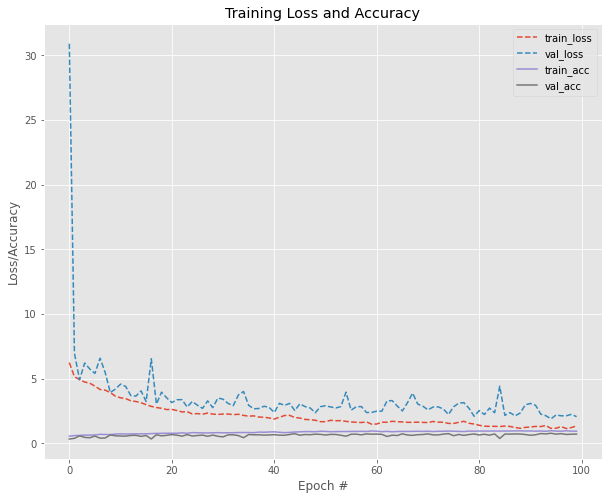

In [30]:
# plot the training loss and accuracy
plt.style.use("ggplot")
fig, ax = plt.subplots(1,1,figsize=(10,8))

ax.plot(np.arange(0, 100), history.history["loss"], label="train_loss",linestyle='--')
ax.plot(np.arange(0, 100), history.history["val_loss"], label="val_loss",linestyle='--')
ax.plot(np.arange(0, 100), history.history["accuracy"], label="train_acc")
ax.plot(np.arange(0, 100), history.history["val_accuracy"], label="val_acc")
ax.set_title("Training Loss and Accuracy")
ax.set_xlabel("Epoch #")
ax.set_ylabel("Loss/Accuracy")
ax.legend()
plt.show()

In [34]:
print("[INFO] {} kWh of electricity used since the begining".format(tracker.final_emissions_data.energy_consumed))
print("[INFO] Energy consumed for RAM: {} kWh".format(tracker.final_emissions_data.ram_energy))
print("[INFO] Energy consumed for all GPU: {} kWh".format(tracker.final_emissions_data.gpu_energy))
print("[INFO] Energy consumed for all CPU: {} kWh".format(tracker.final_emissions_data.cpu_energy))
print("[INFO] CO2 emission {}(in Kg)".format(tracker.final_emissions_data.emissions))

[INFO] 0.007789590265322774 kWh of electricity used since the begining
[INFO] Energy consumed for RAM: 0.0010207245144651163 kWh
[INFO] Energy consumed for all GPU: 0.0053824581665745715 kWh
[INFO] Energy consumed for all CPU: 0.0013864075842830868 kWh
[INFO] CO2 emission 0.003525730383940344(in Kg)


In [35]:
# evaluate the network
print("[INFO] evaluating network...")
predictions = model.predict(val_x, batch_size=32)
print(classification_report(val_y.argmax(axis=1),
                            predictions.argmax(axis=1),
                            target_names=lb.classes_))

[INFO] evaluating network...
18/18 [==============================] - 0s 8ms/step
              precision    recall  f1-score   support

        cats       0.72      0.65      0.68       198
        dogs       0.59      0.76      0.67       206
       panda       0.93      0.71      0.81       159

    accuracy                           0.71       563
   macro avg       0.75      0.71      0.72       563
weighted avg       0.73      0.71      0.71       563



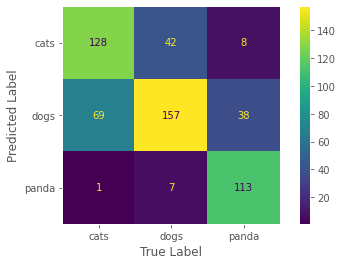

In [36]:
fig_confusion_matrix, ax = plt.subplots(1,1,figsize=(7,4))
ConfusionMatrixDisplay(confusion_matrix(predictions.argmax(axis=1),
                                        val_y.argmax(axis=1)),
                       display_labels=lb.classes_).plot(values_format=".0f",ax=ax)

ax.set_xlabel("True Label")
ax.set_ylabel("Predicted Label")
ax.grid(False)
plt.show()

In [37]:
# Uploading figures
logger.info("Uploading figures")
run.log(
    {
        "confusion_matrix": wandb.Image(fig_confusion_matrix),
        # "other_figure": wandb.Image(other_fig)
    }
)

25-10-2022 12:13:50 Uploading figures


In [38]:
# Evaluation Metrics
logger.info("Validation Evaluation metrics")
fbeta = fbeta_score(val_y.argmax(axis=1), 
                    predictions.argmax(axis=1), 
                    beta=1, zero_division=1,average='weighted')
precision = precision_score(val_y.argmax(axis=1),
                            predictions.argmax(axis=1),
                            zero_division=1,average='weighted')
recall = recall_score(val_y.argmax(axis=1),
                      predictions.argmax(axis=1),
                      zero_division=1,average='weighted')
acc = accuracy_score(val_y.argmax(axis=1),
                     predictions.argmax(axis=1))

logger.info("Validation Accuracy: {}".format(acc))
logger.info("Validation Precision: {}".format(precision))
logger.info("Validation Recall: {}".format(recall))
logger.info("Validation F1: {}".format(fbeta))

run.summary["Acc"] = acc
run.summary["Precision"] = precision
run.summary["Recall"] = recall
run.summary["F1"] = fbeta
# number of parameters
run.summary["Count_Params"] = model.count_params()
# energy unit is kWh
run.summary["Energy_Consumed"] = tracker.final_emissions_data.energy_consumed
run.summary["Energy_RAM"] = tracker.final_emissions_data.ram_energy
run.summary["Energy_GPU"] = tracker.final_emissions_data.gpu_energy
run.summary["Energy_CPU"] = tracker.final_emissions_data.cpu_energy
# kg
run.summary["CO2_Emissions"] = tracker.final_emissions_data.emissions

25-10-2022 12:13:51 Validation Evaluation metrics
25-10-2022 12:13:51 Validation Accuracy: 0.7069271758436945
25-10-2022 12:13:51 Validation Precision: 0.7342401448228615
25-10-2022 12:13:51 Validation Recall: 0.7069271758436945
25-10-2022 12:13:51 Validation F1: 0.7118468149891755


In [39]:
logger.info("Dumping the model and encoder artifacts to the disk")

# Save the artifacts using joblib
joblib.dump(lb, args["encoder"])
model.save(os.path.join(wandb.run.dir, args["inference_model"]))

25-10-2022 12:13:51 Dumping the model and encoder artifacts to the disk


In [40]:
# encoder artifact
artifact = wandb.Artifact(args["encoder"],
                          type="INFERENCE_MODEL",
                          description="A json file representing the target encoder"
                          )

logger.info("Logging the target encoder artifact")
artifact.add_file(args["encoder"])
run.log_artifact(artifact)

25-10-2022 12:13:52 Logging the target encoder artifact


In [41]:
# inference model artifact
artifact = wandb.Artifact(args["inference_model"],
                          type="INFERENCE_MODEL",
                          description="A json file representing the inference model"
                          )

logger.info("Logging the inference model artifact")
artifact.add_file(os.path.join(wandb.run.dir, args["inference_model"]))
run.log_artifact(artifact)

25-10-2022 12:13:52 Logging the inference model artifact


In [42]:
run.finish()

accuracy,▂▃▄▄▆▆▇▇▇▇████▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▅▅▆▆▇█▇████
epoch,▁▁▂▂▃▄▄▅▅▆▆▇▇█▁▂▂▃▄▄▅▅▆▆▇▇█▁▂▂▃▃▄▅▅▆▆▇▇█
loss,▄▄▃▂▂▂▂▁▁▁▁▁▁▁██▅▄▅▄▄▂▂▂▁▁▁▄▃▂▂▂▂▁▁▁▁▁▁▁
val_accuracy,▂▄▆▆▅▆█▇▇▆▆█▇▇▁▅▅▅▄▁▅▂▃▅▂▄▄▃▆▇▅▇▇▇█▆▆█▇█
val_loss,▃▂▂▁▂▂▁▁▁▁▁▁▁▁█▃▂▃▂▂▂▂▁▁▁▁▁▂▁▁▁▁▁▁▁▂▁▁▁▁
Acc,0.70693
CO2_Emissions,0.00353
Count_Params,58331907
Energy_CPU,0.00139
Energy_Consumed,0.00779
Energy_GPU,0.00538
